In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sps
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1.3)

In [35]:
val_data = pd.read_csv('val_dataset.csv')
text, emotions = val_data['Text'], val_data['Emotion']
predictions = pd.read_csv('shuffled_predictions.csv')
shuffled_accuracy = pd.DataFrame((predictions.values == emotions.values.reshape(-1, 1)) * 1, columns=predictions.columns)

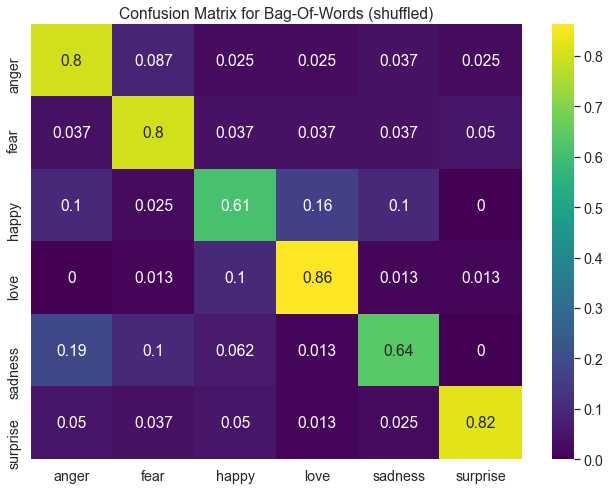

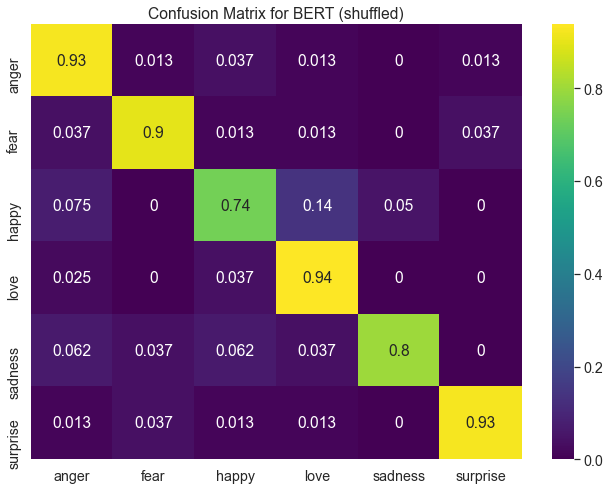

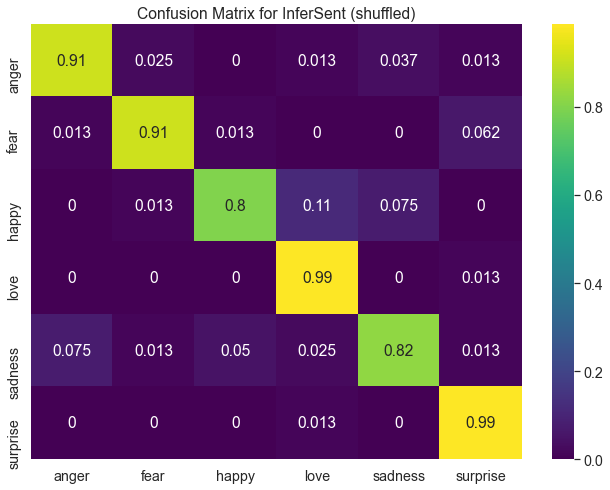

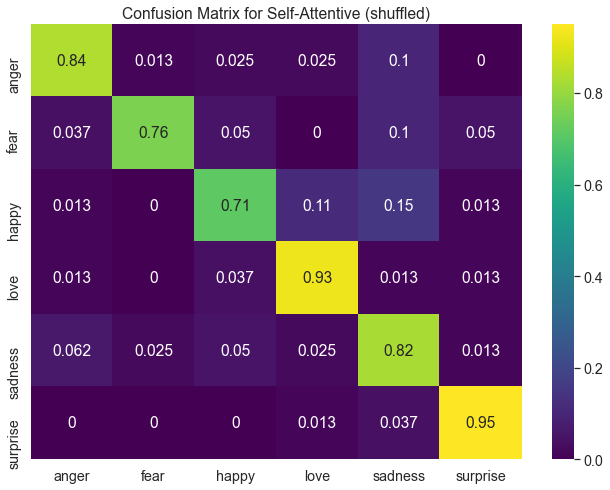

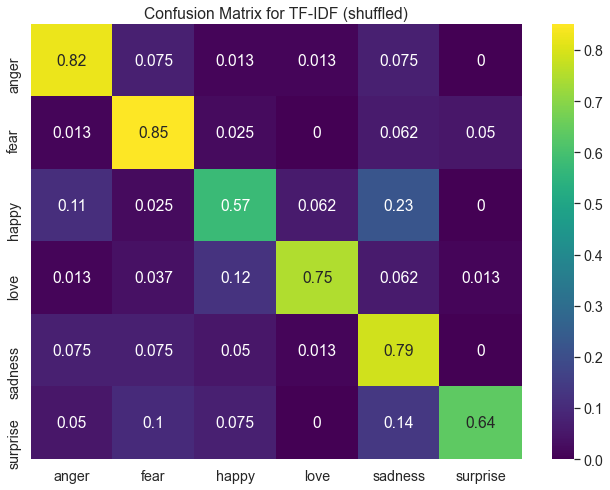

In [36]:
columns = list(predictions.columns)
columns[-1], columns[1] = columns[1], columns[-1]

for column in columns:
    cf_matrix = confusion_matrix(emotions, predictions[column], normalize='true', labels=np.unique(emotions))
    cf_matrix = pd.DataFrame(cf_matrix, columns=np.unique(emotions), index=np.unique(emotions))

    plt.figure(figsize=(11, 8))
    plt.title('Confusion Matrix for {} (shuffled)'.format(column))
    sns.heatmap(cf_matrix, cmap='viridis', annot=True);

In [65]:
predictions = pd.read_csv('val_predictions.csv').drop(columns=['Unnamed: 0'])
accuracy = pd.DataFrame((predictions.values == emotions.values.reshape(-1, 1)) * 1, columns=predictions.columns)

columns = ['Bag-Of-Words', 'TF-IDF', 'InferSent', 'Self-Attentive', 'BERT']
accuracy = accuracy.reindex(columns=columns)

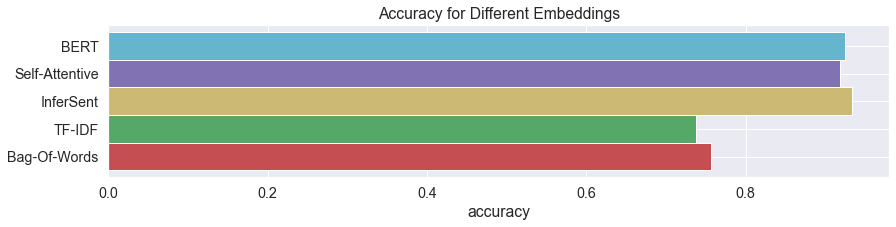

In [79]:
plt.figure(figsize=(14, 2.8))
plt.title('Accuracy for Different Embeddings')
plt.barh(shuffled_accuracy.columns, shuffled_accuracy.mean(), 1, color=['r', 'g', 'y', 'm', 'c'])
plt.barh(accuracy.columns, accuracy.mean(), 1, color=['r', 'g', 'y', 'm', 'c'])
plt.xlabel('accuracy')
plt.show()

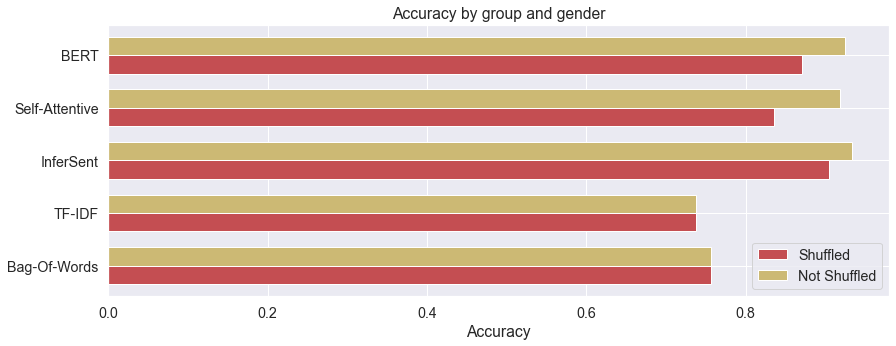

In [82]:
N = 5

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

plt.subplots(figsize=(14, 5))
plt.barh(ind, shuffled_accuracy.mean(), width, color='r')
plt.barh(ind + width, accuracy.mean(), width, color='y')
plt.xlabel('Accuracy')
plt.title('Accuracy by group and gender')
plt.yticks(ind + width / 2, accuracy.columns)
plt.legend((rects1[0], rects2[0]), ('Shuffled', 'Not Shuffled'))
plt.show()

In [86]:
for name, acc, shuffled_acc in zip(accuracy.columns, accuracy.mean(), shuffled_accuracy.mean()):
    print('{} accuracy: {}'.format(name, np.round((acc - shuffled_acc) * 100, 3)))

Bag-Of-Words accuracy: 0.0
TF-IDF accuracy: 0.0
InferSent accuracy: 2.917
Self-Attentive accuracy: 8.333
BERT accuracy: 5.417


# Statistical Hypothesis Testing (Z-criterion)

$X_1$ &mdash; accuracy for not shuffled data, $X_2$ &mdash; accuracy for shuffled data
  
$H_0\colon \overline{X_1} = \overline{X_2}$  
  
$H_1\colon \overline{X_1} > \overline{X_2}$

In [22]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sps.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sps.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sps.norm.cdf(z_stat)


def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

In [26]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_rel(accuracy.iloc[:, 0], accuracy.iloc[:, 1]), 'greater'))

p-value: 0.001255
